In [13]:
import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import cv2, skimage
from IPython.display import clear_output

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [88]:
file = "/run/media/dsarkar/One Touch/Avalanche in petri dish/new/7.MP4" # The file that will be analysed

cam = cv2.VideoCapture(file)

currentframe = 0
fps = 120
initialtime = 0 # Initial Time mentioned in seconds
length = 10 #Length of the clip to be analysed mentioned in seconds
skip = 30 #Number of frames to skip
data = []
num = []
property_id = int(cv2.CAP_PROP_FRAME_COUNT)  
leng = int(cv2.VideoCapture.get(cam, property_id))

cam.set(cv2.CAP_PROP_POS_FRAMES, int(initialtime*fps))
counter = 0
rad = []
while currentframe <= length*120:
    ret,frame = cam.read()
    cam.set(cv2.CAP_PROP_POS_FRAMES, int((initialtime*fps) + currentframe)-1)

    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        crop_img = gray
        circles = cv2.HoughCircles(crop_img, cv2.HOUGH_GRADIENT, 0.001, 18, param1=60, param2=6, minRadius=9, maxRadius=10)
        circles = circles[0, :]
        num.append(len(circles))
        for c in circles:
            #crop_img=cv2.circle(crop_img, (int(c[0]),int(c[1])), int(c[2]), (0,0,255), 1)
            rad.append(int(c[2]))
            data.append({'y':c[1], 'x':c[0] , 'frame':counter})
        #cv2.imshow("Frame", crop_img)
        #k = cv2.waitKey(1)
        #if k == 113:
        #    break
        #if currentframe == 10:
        #    gray1 = crop_img
        print(round((currentframe/(length*fps))*100))
        clear_output(wait=True)
    currentframe += skip
    counter += 1
    

100


In [89]:
# Track the bubbles with a memory of 10 frames using trackpy
features = pd.DataFrame(data)
cam.release()
cv2.destroyAllWindows()
t = tp.link_df(features, 2, memory=10)
del data
del features

Frame 40: 569 trajectories present.


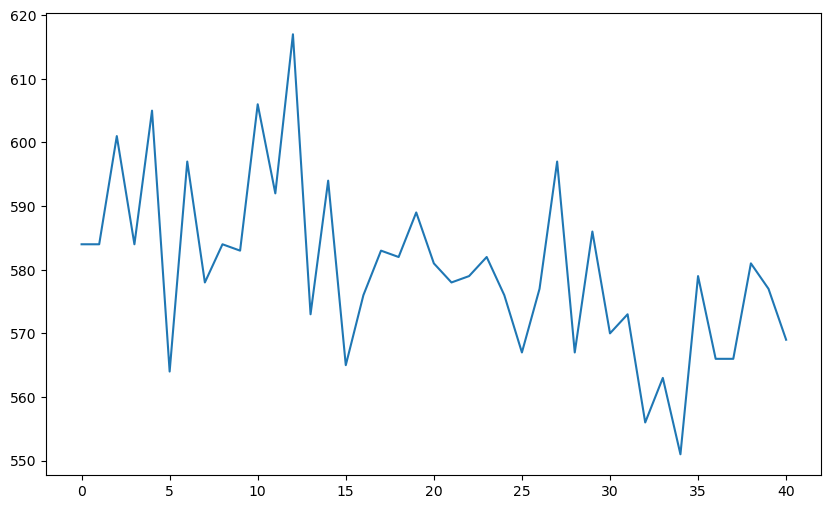

0
Before: 10056
After: 4697


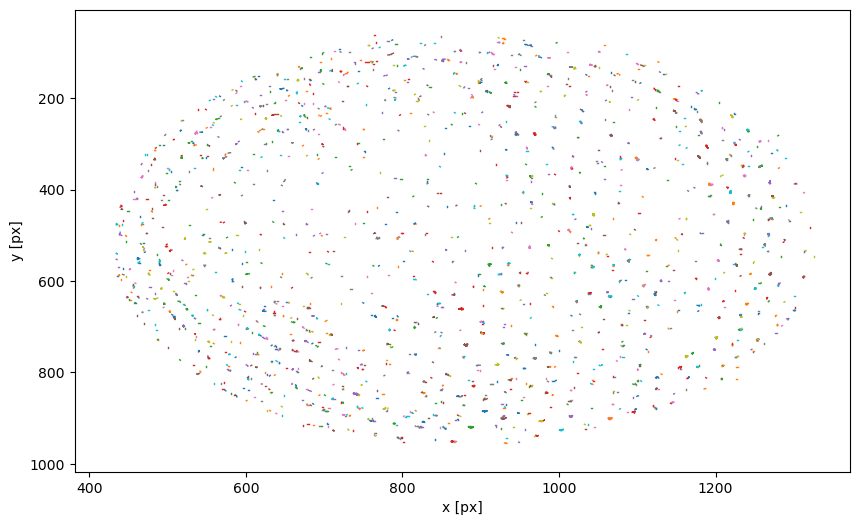

9.0


In [90]:
plt.plot(range(len(num)),num)
plt.show()

N_0 = num[0]
t_h = 0
for i in range(len(num)):
    if num[i] <= N_0//2:
        print('T 1/2 assigned')
        t_h = i
        break
    else:
        pass
print(t_h)

# Remove spurious tracked particles that do not survive for more than 10 frames
t1 = tp.filter_stubs(t,2)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

plt.figure()
tp.plot_traj(t1);

#t2 = t1[t1.particle.duplicated(keep=False)].sort_values("particle")
#t2.index.names = ['ID']
#t2 = t2.reset_index()

def avg(x):
    s = 0
    for i in x:
        s+=i
    return s/len(x)
# Calculating average radius of bubbles
radius = avg(rad)
print(radius)

In [91]:
t1.columns = ['y','x','frames','particle']
t2=t1

So now, there are two things that are to be done - 
- [-] Process a dict that has the keys as the bubble ids, and the value as the frame in which it bursts
- [-] Find a function that can find and return the IDs of the closest neighbours of the bubbles

In [92]:
# This function finds the closest 6 neighbouring bubble ids at a particular frame
def neighbour(id,frame):
    global t2
    global radius
    t4 = t2.loc[(t2['particle'] == id)&(t2['frames']==frame)]
    if list(t4['y']) == []:
        return 0
    t4 = dict(t4)
    #print(t4)
    y = int(t4['y'])
    x = int(t4['x'])
    t5 = t2.loc[(t2['x']<x+radius*3)&(t2['y']<y+radius*3)&(t2['x']>x-radius*3)&(t2['y']>y-radius*3)&(t2['frames']==frame)&(t2['particle']!=id)]
    return list(t5['particle'])

In [93]:
list(dict(t2.loc[(t2['particle'] == 2000)&(t2['frames']==1)])['y'])

[]

In [94]:
neighbour(2000,1)

0

In [95]:
# Creates a dictionary where the keys are the bubble ids and the values are the frame no. in which they burst
no = t2['particle'].nunique()
bursts = dict()
for i in range(no):
    t3 = t2.loc[t2['particle']==i].sort_values('frames')
    try:
        #print(int(t3.tail(1).frame))
        bursts[i] = int(t3.tail(1).frames)
    except:
        pass

In [96]:
# Intermediate Avalanche size detection for the video data
# This finds the total avalanche size of all the avalanches in a given frame
avs = []
tim = []
for i in range(0,counter -1):
    av = 0
    bur = [k for k, v in bursts.items() if v == i]
    #print(len(bur))
    counted = []
    for j in bur:
        neigh = neighbour(j,i)
        for x in neigh:
            if x in counted:
                continue
            try:
                if int(bursts[x] - i) == 2: # Change this value to affect relaxation threshold
                    av+=1
                    counted.append(x)
                    bur.append(x)
                    #print('cooperative')
                else:
                    pass
            except:
                pass
    print('Total avalanche size -> ', av,' at time '+str(i*skip*(1/fps))+'s')
    avs.append(av)
    tim.append(i*skip*(1/fps))

Total avalanche size ->  0  at time 0.0s
Total avalanche size ->  23  at time 0.25s
Total avalanche size ->  4  at time 0.5s
Total avalanche size ->  3  at time 0.75s
Total avalanche size ->  5  at time 1.0s
Total avalanche size ->  0  at time 1.25s
Total avalanche size ->  4  at time 1.5s
Total avalanche size ->  5  at time 1.75s
Total avalanche size ->  6  at time 2.0s
Total avalanche size ->  11  at time 2.25s
Total avalanche size ->  16  at time 2.5s
Total avalanche size ->  11  at time 2.75s
Total avalanche size ->  18  at time 3.0s
Total avalanche size ->  1  at time 3.25s
Total avalanche size ->  9  at time 3.5s
Total avalanche size ->  15  at time 3.75s
Total avalanche size ->  3  at time 4.0s
Total avalanche size ->  4  at time 4.25s
Total avalanche size ->  7  at time 4.5s
Total avalanche size ->  0  at time 4.75s
Total avalanche size ->  2  at time 5.0s
Total avalanche size ->  1  at time 5.25s
Total avalanche size ->  0  at time 5.5s
Total avalanche size ->  1  at time 5.75

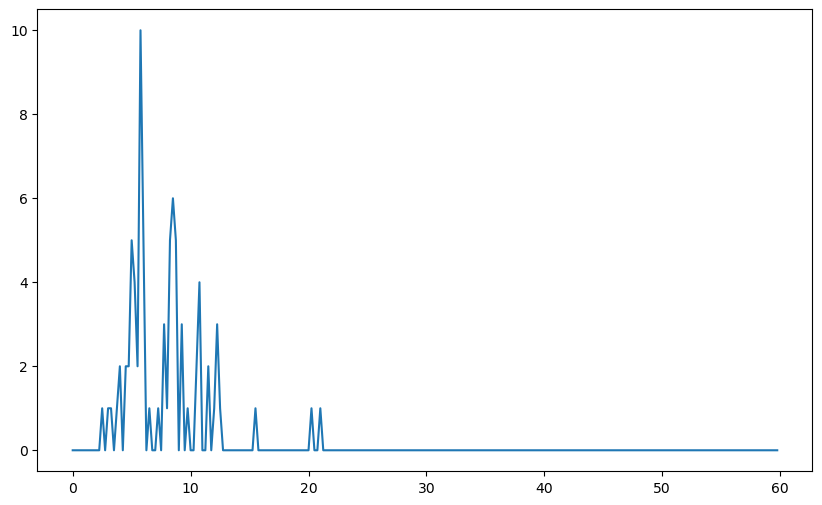

In [95]:
plt.plot(tim,avs)

In [97]:
a = dict()
for i in avs:
    if i in a.keys():
        a[i] += 1
    else:
        a[i] = 1

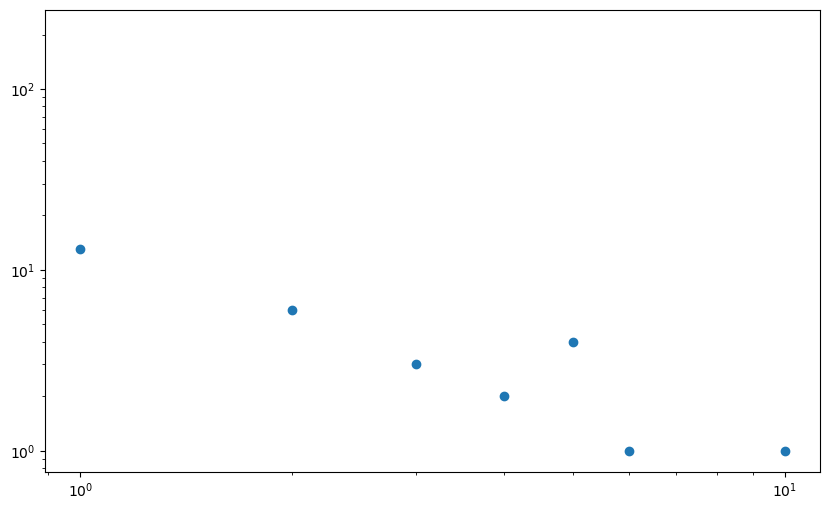

In [101]:
x = []
y = []
for i in a.keys():
    x.append(i)
    y.append(a[i])
plt.yscale('log')
plt.xscale('log')
plt.scatter(x,y)
plt.show()

## Final code for the analysis of batch of video

Frame 120: 563 trajectories present.


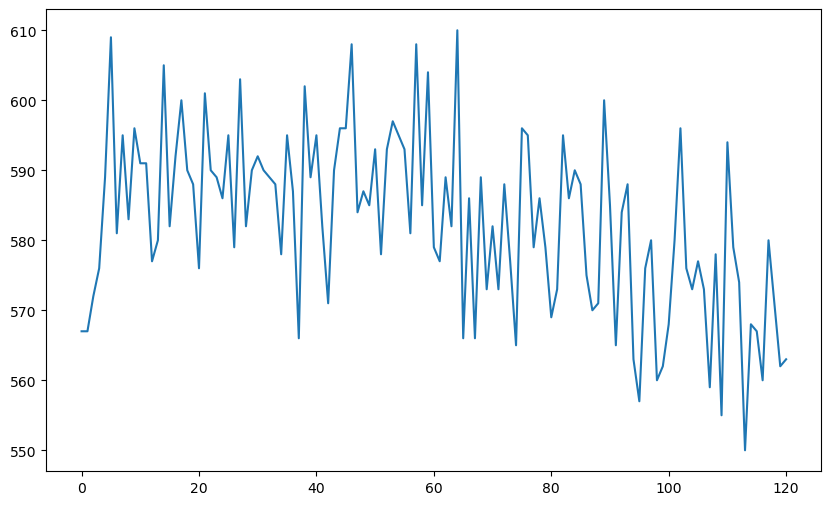

0
Before: 15486
After: 5888


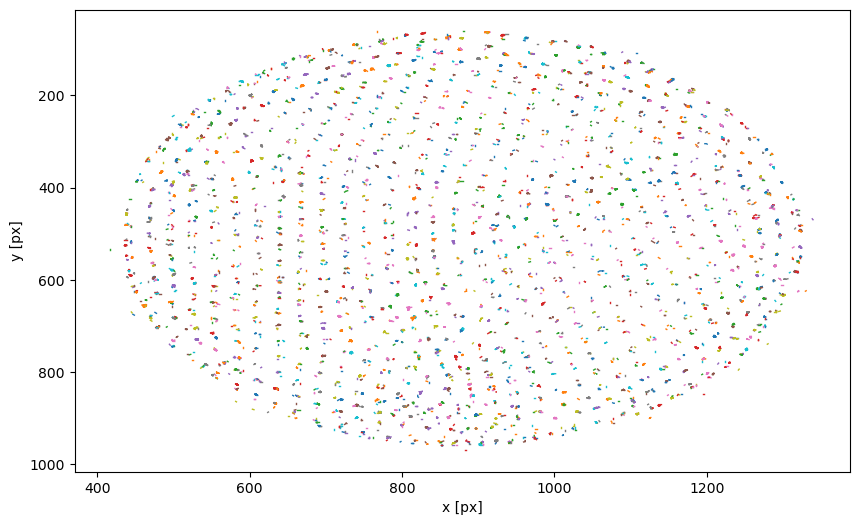

9.0
Total avalanche size ->  0  at time 0.0s
Total avalanche size ->  0  at time 0.08333333333333333s
Total avalanche size ->  0  at time 0.16666666666666666s
Total avalanche size ->  0  at time 0.25s
Total avalanche size ->  0  at time 0.3333333333333333s
Total avalanche size ->  1  at time 0.4166666666666667s
Total avalanche size ->  0  at time 0.5s
Total avalanche size ->  0  at time 0.5833333333333334s


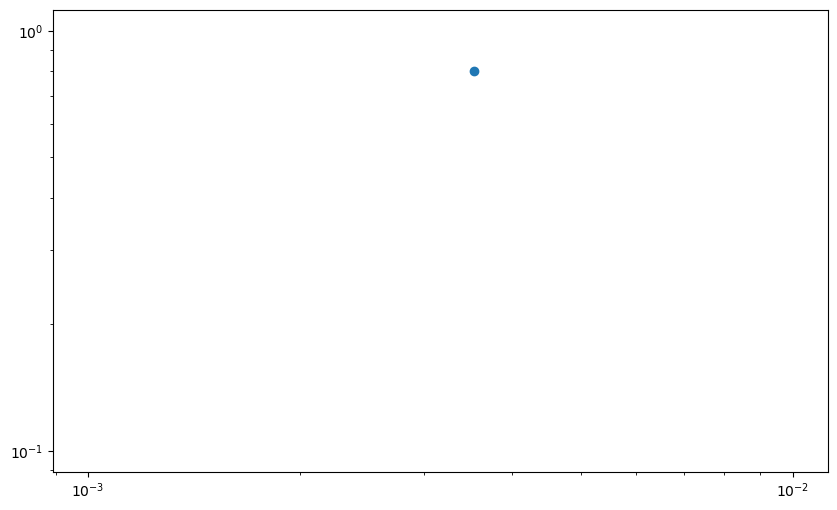

In [11]:
import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import cv2, skimage
from IPython.display import clear_output

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

xs = []
ys = []

for p in range(1,9):
    file = "/run/media/dsarkar/One Touch/Avalanche in petri dish/new/"+str(p)+".MP4" # The file that will be analysed
    cam = cv2.VideoCapture(file)
    
    currentframe = 0
    fps = 120
    initialtime = 0 # Initial Time mentioned in seconds
    length = 10 #Length of the clip to be analysed mentioned in seconds
    skip = 10 #Number of frames to skip
    data = []
    num = []
    property_id = int(cv2.CAP_PROP_FRAME_COUNT)  
    leng = int(cv2.VideoCapture.get(cam, property_id))
    
    cam.set(cv2.CAP_PROP_POS_FRAMES, int(initialtime*fps))
    counter = 0
    rad = []
    while currentframe <= length*120:
        ret,frame = cam.read()
        cam.set(cv2.CAP_PROP_POS_FRAMES, int((initialtime*fps) + currentframe)-1)
    
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            crop_img = gray
            circles = cv2.HoughCircles(crop_img, cv2.HOUGH_GRADIENT, 0.001, 18, param1=60, param2=6, minRadius=9, maxRadius=10)
            circles = circles[0, :]
            num.append(len(circles))
            for c in circles:
                #crop_img=cv2.circle(crop_img, (int(c[0]),int(c[1])), int(c[2]), (0,0,255), 1)
                rad.append(int(c[2]))
                data.append({'y':c[1], 'x':c[0] , 'frame':counter})
            #cv2.imshow("Frame", crop_img)
            #k = cv2.waitKey(1)
            #if k == 113:
            #    break
            #if currentframe == 10:
            #    gray1 = crop_img
            print(round((currentframe/(length*fps))*100))
            clear_output(wait=True)
        currentframe += skip
        counter += 1
    
    # Track the bubbles with a memory of 10 frames using trackpy
    features = pd.DataFrame(data)
    cam.release()
    cv2.destroyAllWindows()
    t = tp.link_df(features, 3, memory=10)
    del data
    del features
    
    plt.plot(range(len(num)),num)
    plt.show()
    
    N_0 = num[0]
    t_h = 0
    for i in range(len(num)):
        if num[i] <= N_0//2:
            print('T 1/2 assigned')
            t_h = i
            break
        else:
            pass
    print(t_h)
    
    # Remove spurious tracked particles that do not survive for more than 10 frames
    t1 = tp.filter_stubs(t,3)
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    
    plt.figure()
    tp.plot_traj(t1);
    
    #t2 = t1[t1.particle.duplicated(keep=False)].sort_values("particle")
    #t2.index.names = ['ID']
    #t2 = t2.reset_index()
    
    def avg(x):
        s = 0
        for i in x:
            s+=i
        return s/len(x)
    # Calculating average radius of bubbles
    radius = avg(rad)
    print(radius)
    
    t1.columns = ['y','x','frames','particle']
    t2=t1
    
    # This function finds the closest 6 neighbouring bubble ids at a particular frame
    def neighbour(id,frame):
        global t2
        global radius
        t4 = t2.loc[(t2['particle'] == id)&(t2['frames']==frame)]
        if list(t4['y']) == []:
            return 0
        t4 = dict(t4)
        #print(t4)
        y = int(t4['y'])
        x = int(t4['x'])
        t5 = t2.loc[(t2['x']<x+radius*3)&(t2['y']<y+radius*3)&(t2['x']>x-radius*3)&(t2['y']>y-radius*3)&(t2['frames']==frame)&(t2['particle']!=id)]
        return list(t5['particle'])
    
    # Creates a dictionary where the keys are the bubble ids and the values are the frame no. in which they burst
    no = t2['particle'].nunique()
    bursts = dict()
    for i in range(no):
        t3 = t2.loc[t2['particle']==i].sort_values('frames')
        try:
            #print(int(t3.tail(1).frame))
            bursts[i] = int(t3.tail(1).frames)
        except:
            pass
    
    # Intermediate Avalanche size detection for the video data
    # This finds the total avalanche size of all the avalanches in a given frame
    avs = []
    tim = []
    for i in range(0,counter -1):
        av = 0
        bur = [k for k, v in bursts.items() if v == i]
        #print(len(bur))
        counted = []
        for j in bur:
            neigh = neighbour(j,i)
            for x in neigh:
                if x in counted:
                    continue
                try:
                    if int(bursts[x] - i) == 2: # Change this value to affect relaxation threshold
                        av+=1
                        counted.append(x)
                        bur.append(x)
                        #print('cooperative')
                    else:
                        pass
                except:
                    pass
        if av != 0 and av!=1:
            ys.append(av)
            break
        else:
            pass
        print('Total avalanche size -> ', av,' at time '+str(i*skip*(1/fps))+'s')

a = dict()
for i in ys:
    x = i/num[0]
    if x in a.keys():
        a[x] += 1
    else:
        a[x] = 1
ys = []
xs = []
for i in a.keys():
    xs.append(i)
    ys.append(a[i]/10) #20 here is the placeholder for the number of runs that we do

plt.xscale('log')
plt.yscale('log')
plt.scatter(xs,ys)
plt.show()

In [12]:
a

{0.003527336860670194: 8}

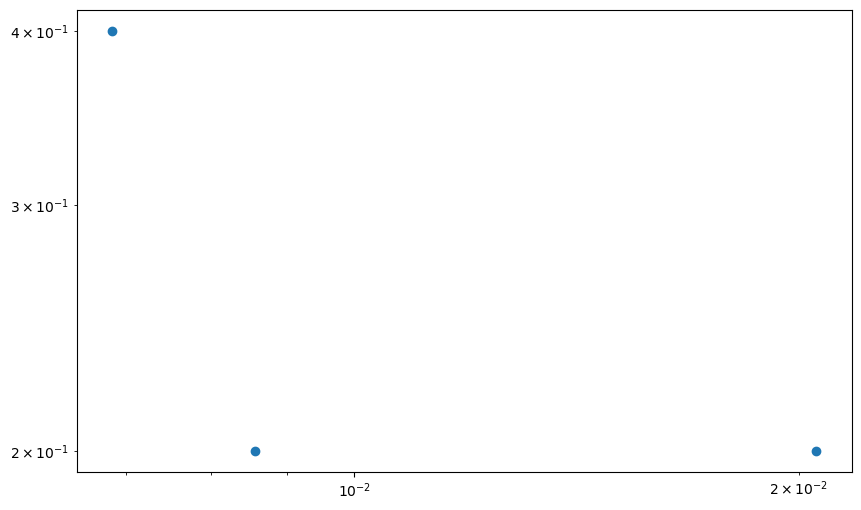

In [97]:
ys = [12,4,5,4,4,12,5,4]
a = dict()
for i in ys:
    x = i/num[0]
    if x in a.keys():
        a[x] += 1
    else:
        a[x] = 1
ys = []
xs = []
for i in a.keys():
    xs.append(i)
    ys.append(a[i]/10) #20 here is the placeholder for the number of runs that we do

plt.xscale('log')
plt.yscale('log')
plt.scatter(xs,ys)
plt.show()